In [ ]:
import sys, os

root_path = os.path.abspath(os.path.join(os.getcwd(), ".."))
if root_path not in sys.path:
    sys.path.append(root_path)

In [ ]:
from data.load_tinyimagenet import *

train_loader, val_loader, test_loader = get_tinyimagenet200_hf_dataloaders(
    batch_size=64, data_dir="./data",
    num_workers=2,
    val_split=0.1, seed=77)

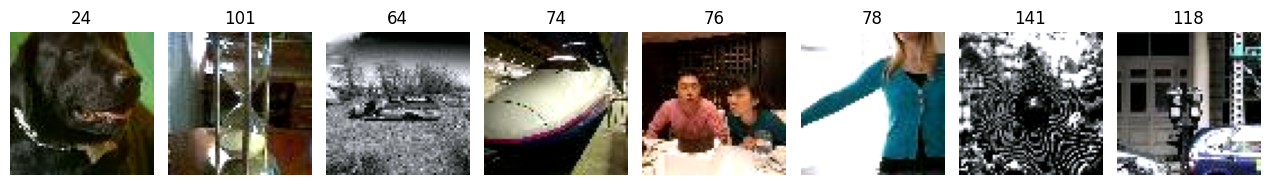

In [3]:
import matplotlib.pyplot as plt
import torch

def show_batch(images, labels, n=8):
    mean = torch.tensor((0.5071, 0.4867, 0.4408)).view(1,3,1,1)
    std  = torch.tensor((0.2675, 0.2565, 0.2761)).view(1,3,1,1)

    imgs = images[:n].cpu() * std + mean
    imgs = imgs.clamp(0, 1)

    fig, axes = plt.subplots(1, n, figsize=(1.6*n, 2))
    for i in range(n):
        axes[i].imshow(imgs[i].permute(1,2,0))
        axes[i].set_title(str(labels[i].item()))
        axes[i].axis("off")
    plt.tight_layout()
    plt.show()


images, labels = next(iter(train_loader))
show_batch(images, labels, n=8)

---

# Training

In [ ]:
import timm
import torch.nn as nn

device = 'cuda'
model_resnet50 = timm.create_model(
    "resnet50",
    pretrained=False,
    num_classes=200).to(device)

model_resnet50.conv1 = nn.Conv2d(
    in_channels=3, 
    out_channels=64, 
    kernel_size=3, 
    stride=1, 
    padding=1, 
    bias=False)

model_resnet50.maxpool = nn.MaxPool2d(
    kernel_size=3, 
    stride=2, 
    padding=1)

In [17]:
def count_trainable_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

n_params = count_trainable_parameters(model_resnet50)
print(f"Trainable parameters: {n_params:,}")

Trainable parameters: 23,910,152


In [ ]:
import random, numpy as np

from src.training.train_full_model import * 
from src.training.metrics import * 
from src.training.eval_one_epoch_logs import *

seed = 77
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

random.seed(seed);
np.random.seed(seed)
torch.backends.cudnn.benchmark = True


history, model_resnet50 = train_model(
    model=model_resnet50,
    train_loader=train_loader,
    epochs=25,
    val_loader=val_loader,
    device=device,

    lr=5e-4,
    weight_decay=0.05,

    autocast_dtype="fp16" if device == "cuda" else "fp32",
    use_amp=(device == "cuda"),
    grad_clip_norm=4.5,

    warmup_ratio=0.05,
    min_lr=1e-6,

    label_smoothing=0.1,

    print_every=400,
    save_path="best_resnet50.pt",
    last_path="last_resnet.pt",
    resume_path=None,

    # Augmentations
    mix_prob=0.5,
    mixup_alpha=0.4,
    cutmix_alpha=0.4,

    num_classes=200,
    channels_last=True)

#T4 

=== Run config ===
device=cuda | amp=True | autocast_dtype=fp16 | channels_last=True
epochs=25 | steps/epoch=1406 | total_steps=35150 | warmup_steps=1757
batch_size=64 | input_shape=(64, 3, 64, 64) | num_classes=200
opt=AdamW | lr=0.0005 | wd=0.05 | grad_clip_norm=3.0
aug: mix_prob=0.5 | mixup_alpha=0.4 | cutmix_alpha=0.4 | label_smoothing=0.1

=== Epoch 1/25 ===
[train step 400/1406] loss 5.1454 | top1 2.55% | top3 6.16% | top5 8.84% | 727.3 img/s | lr 1.14e-04 | gnorm 2.869 | clip 26.0% | oflow 0 | nonfinite 0 | scale 65536.0
[train step 800/1406] loss 4.9704 | top1 3.98% | top3 9.16% | top5 12.98% | 810.8 img/s | lr 2.28e-04 | gnorm 3.008 | clip 49.1% | oflow 0 | nonfinite 0 | scale 65536.0
[train step 1200/1406] loss 4.8160 | top1 5.39% | top3 12.02% | top5 16.75% | 841.2 img/s | lr 3.41e-04 | gnorm 3.213 | clip 64.1% | oflow 0 | nonfinite 0 | scale 65536.0
[train step 1406/1406] loss 4.7392 | top1 6.22% | top3 13.50% | top5 18.63% | 850.2 img/s | lr 4.00e-04 | gnorm 3.317 | clip 6

---

In [19]:
evaluate_one_epoch(model=model_resnet50,dataloader=test_loader, device=device)

(2.4811497669219973, {'top1': 44.51, 'top3': 61.97, 'top5': 69.33})

In [20]:
import pickle

with open("ResNet50_TinyImagnet200.pkl", "wb") as f:
    pickle.dump(history, f)

In [ ]:
from src.data.load_tinyimagenet_C import *

quick_corruptions = ["gaussian_noise", "motion_blur", "jpeg_compression", "fog", "pixelate"]

results_quick = evaluate_tinyc_suite(
    model=model_resnet50,
    evaluate_one_epoch_fn=evaluate_one_epoch,
    reference_clean_loader=test_loader,
    data_dir="./data",
    batch_size=128,
    img_size=64,
    num_workers=2,
    corruptions=quick_corruptions,
    severities=(1, 3, 5),
    verbose=True)

print(summarize_tinyc_results(results_quick, metric_key="top1"))
print(summarize_tinyc_results(results_quick, metric_key="top5"))

[Tiny-ImageNet-C] Downloading tar to: data/Tiny-ImageNet-C.tar
[Tiny-ImageNet-C] Extracting: data/Tiny-ImageNet-C.tar


/tmp/ipykernel_55/2943412608.py:126: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  tf.extractall(data_dir)


    gaussian_noise | s=1 | n=9100 | loss=3.5604 | top1=26.67 | top5=50.23
    gaussian_noise | s=3 | n=9100 | loss=5.1375 | top1=10.46 | top5=25.14
    gaussian_noise | s=5 | n=9100 | loss=5.9490 | top1=5.03 | top5=13.03
       motion_blur | s=1 | n=9100 | loss=4.3270 | top1=16.97 | top5=37.56
       motion_blur | s=3 | n=9100 | loss=5.0130 | top1=10.37 | top5=26.62
       motion_blur | s=5 | n=9100 | loss=5.3968 | top1=7.47 | top5=21.25
  jpeg_compression | s=1 | n=9100 | loss=3.8163 | top1=23.11 | top5=45.95
  jpeg_compression | s=3 | n=9100 | loss=3.9119 | top1=21.92 | top5=43.87
  jpeg_compression | s=5 | n=9100 | loss=4.2069 | top1=18.05 | top5=38.47
               fog | s=1 | n=9100 | loss=3.8369 | top1=22.89 | top5=45.22
               fog | s=3 | n=9100 | loss=4.6181 | top1=13.11 | top5=31.81
               fog | s=5 | n=9100 | loss=5.8847 | top1=4.88 | top5=15.18
          pixelate | s=1 | n=9100 | loss=3.4289 | top1=28.12 | top5=52.80
          pixelate | s=3 | n=9100 | loss=

In [ ]:
test_loader_clean_182 = get_clean_test_loader_intersection_182(
    test_loader_clean=test_loader,       
    reference_train_loader=train_loader,  
    data_dir="./data",
    corruption_name="motion_blur",
    corruption_level=3,
    batch_size=128,
    num_workers=2)

clean_loss, clean_metrics = evaluate_one_epoch(model=model_resnet50, dataloader=test_loader_clean_182)
print("clean_182:", clean_loss, clean_metrics)

[clean∩C] keep_classes=182 | drop_classes=18
[clean∩C] keep_samples=9100 / total=10000
clean_182: 2.43132882809901 {'top1': 45.30769230769231, 'top3': 62.73626373626374, 'top5': 70.0989010989011}
